# Explanations of chest X-ray predictions using a Decision Tree

### Goal: identify patients likely to be harmed by AI

#### Idea: Try to identify demographic or technical shortcuts in the convolutional neural network for CXR classification by fitting a decision tree to the predictions of the model.

In this case, the decision tree is used only to analyze the possible influence of sensitive attributes on the predictions.

Hence, the analysis is performed on the whole set of examples and there is no train/test split.

In [22]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    root_mean_squared_error,
    accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

In [23]:
# Read the test set predictions
df = pd.read_csv("new_models_data/TEST_score_tabular.csv")

# Handle date format
df["AcquisitionDate"] = pd.to_datetime(df["AcquisitionDate"], format="%Y%m%d")

# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop rows with any missing values
df.dropna(inplace=True)

In [24]:
df.head(3)

,study_id,subject_id,hadm_id,dicom,Label_0_Logit,Label_0_Prob,Label_0,Label_1_Logit,Label_1_Prob,Label_1,...,hospital_expire_flag,AcquisitionDate,DetectorTemperature,ExposureTime,XRayTubeCurrent,Exposure,ExposureInuAs,weight_kg,height_cm,bmi
0,51332563,17191670,27788568,00000218-9fb20d4e-86045713-8013e08b-0d5bebba,-0.776567,0.315060,0.0,-4.536822,0.010594,0.0,...,0,2176-10-24,28.0,126.0,400.0,50.0,50400.0,219.6,73.0,412.08
4,58437311,12885435,28012963,0001bcde-bb754f26-6b32a474-90653a5d-3730aa89,-0.202620,0.449518,0.0,0.861003,0.702870,1.0,...,1,2126-12-23,32.0,13.0,320.0,4.0,4100.0,125.0,72.0,241.13
5,58437311,12885435,28012963,0001bcde-bb754f26-6b32a474-90653a5d-3730aa89,-0.202620,0.449518,0.0,0.861003,0.702870,1.0,...,1,2126-12-23,32.0,13.0,320.0,4.0,4100.0,123.2,72.0,237.65


The CSV file has many columns. In the following part, we will select a subset of columns for explanations.

In [25]:
df.columns

Index(['study_id', 'subject_id', 'hadm_id', 'dicom', 'Label_0_Logit',
       'Label_0_Prob', 'Label_0', 'Label_1_Logit', 'Label_1_Prob', 'Label_1',
       'Label_2_Logit', 'Label_2_Prob', 'Label_2', 'Label_3_Logit',
       'Label_3_Prob', 'Label_3', 'Label_4_Logit', 'Label_4_Prob', 'Label_4',
       'Label_5_Logit', 'Label_5_Prob', 'Label_5', 'Correct_0', 'Correct_1',
       'Correct_2', 'Correct_3', 'Correct_4', 'Correct_5', 'Total_Label',
       'Total_Correct', 'gender', 'admission_type_mapped', 'admission_type',
       'race', 'discharge_location', 'insurance', 'language', 'race_mapped',
       'ViewPosition', 'anchor_age', 'hospital_expire_flag', 'AcquisitionDate',
       'DetectorTemperature', 'ExposureTime', 'XRayTubeCurrent', 'Exposure',
       'ExposureInuAs', 'weight_kg', 'height_cm', 'bmi'],
      dtype='object')

Below we specify what are the demographic and technical aspects we want to take into account.

In [26]:
# MIMIC demographic columns
demographic_cols = ["anchor_age", "gender", "race_mapped", "language", "insurance"]
demographic_numeric_cols = ["anchor_age"]
demographic_categorical_cols = ["gender", "race_mapped", "language", "insurance"]

# MIMIC acquisition columns
# Without 'AcquisitionDate' for now
acquisition_cols = [
    "ViewPosition",
    "DetectorTemperature",
    "ExposureTime",
    "XRayTubeCurrent",
    "Exposure",
    "ExposureInuAs",
]
acquisition_numeric_cols = [
    "DetectorTemperature",
    "ExposureTime",
    "XRayTubeCurrent",
    "Exposure",
    "ExposureInuAs",
]
acquisition_categorical_cols = ["ViewPosition"]

In [27]:
df[demographic_cols].head()

,anchor_age,gender,race_mapped,language,insurance
0,45,M,White,ENGLISH,Medicaid
4,75,M,White,ENGLISH,Medicare
5,75,M,White,ENGLISH,Medicare
7,47,F,Hispanic or Latino,ENGLISH,Medicaid
8,47,F,Hispanic or Latino,ENGLISH,Medicaid


In [28]:
df[acquisition_cols].head()

,ViewPosition,DetectorTemperature,ExposureTime,XRayTubeCurrent,Exposure,ExposureInuAs
0,LATERAL,28.0,126.0,400.0,50.0,50400.0
4,AP,32.0,13.0,320.0,4.0,4100.0
5,AP,32.0,13.0,320.0,4.0,4100.0
7,LATERAL,28.0,41.0,400.0,16.0,16400.0
8,LATERAL,28.0,41.0,400.0,16.0,16400.0


### Creating and fitting a decision tree

A decision tree needs a compatible representation of categorical variables. We will use one-hot encoding for this purpose.

Numeric attributes do not need preprocessing.

<Axes: xlabel='Total_Correct'>

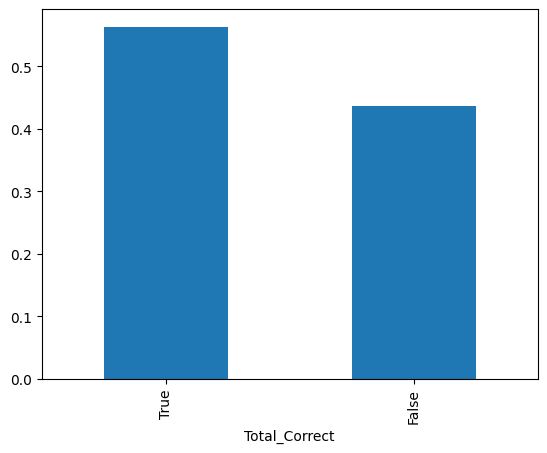

In [29]:
# Define the features
features = demographic_cols + acquisition_cols
categorical_features = demographic_categorical_cols + acquisition_categorical_cols
numerical_features = demographic_numeric_cols + acquisition_numeric_cols

# Select the features
X = df[features]

# Transform the categorical features to one-hot encoding
X_categorical_one_hot = pd.get_dummies(X[categorical_features], drop_first=True)
X = pd.concat([X[numerical_features], X_categorical_one_hot], axis=1)

# Define the target
# We will use the 'Total_Correct' column as the target
# We will consider the task as a binary classification task
# if the 'Total_Correct' is less than 5, we will consider it as High Risk
y = df["Total_Correct"] < 5

class_proportions = y.value_counts(normalize=True)
# Plot the class proportions
class_proportions.plot(kind="bar")

In [36]:
# Create a decision tree classifier
classifier = DecisionTreeClassifier(random_state=0, max_depth=3)

We expect the accuracy to be close to the propotion of the majority class.

In [37]:
classifier.fit(X, y)
y_pred = classifier.predict(X)

score = accuracy_score(y, y_pred)
print("Accuracy: {0:0.4f}".format(score))

Accuracy: 0.6220


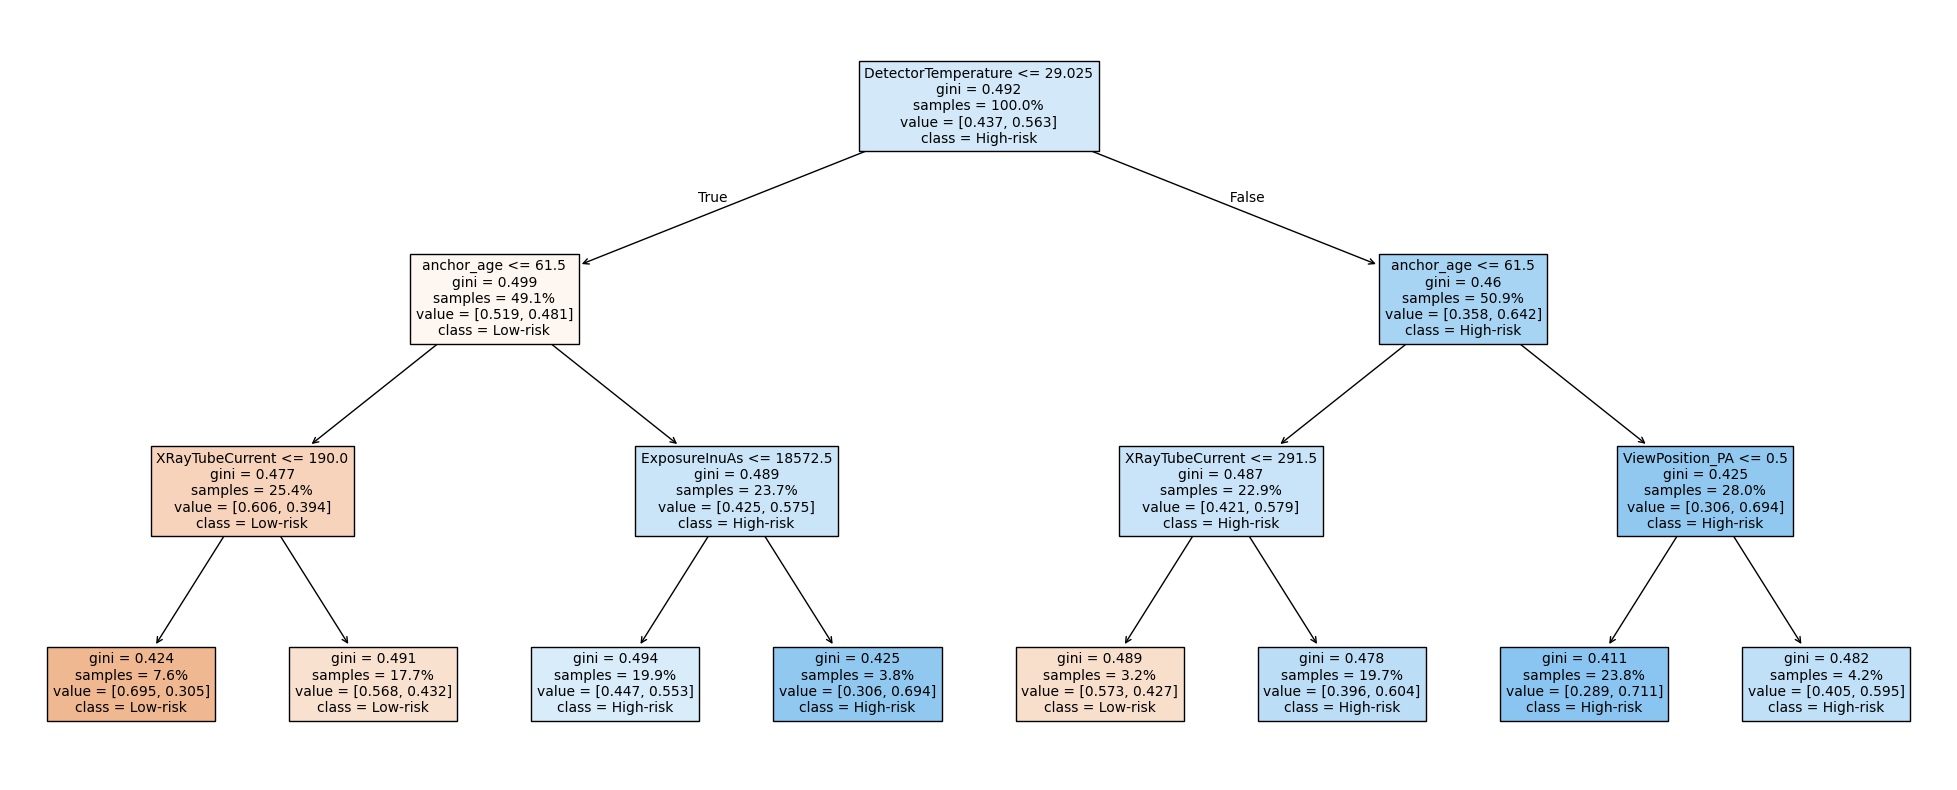

In [38]:
plt.figure(figsize=(25, 10))
plot_tree(
    classifier,
    fontsize=10,
    filled=True,
    proportion=True,
    feature_names=X.columns,
    class_names=["Low-risk", "High-risk"],
)
plt.show()

We can plot the tree using `dtreeviz` for the information on distribution.

In [39]:
import dtreeviz

In [40]:
viz_model = dtreeviz.model(
    classifier,
    X_train=X,
    y_train=y,
    feature_names=X.columns,
    target_name="Correct",
    class_names=["incorrect", "correct"],
)

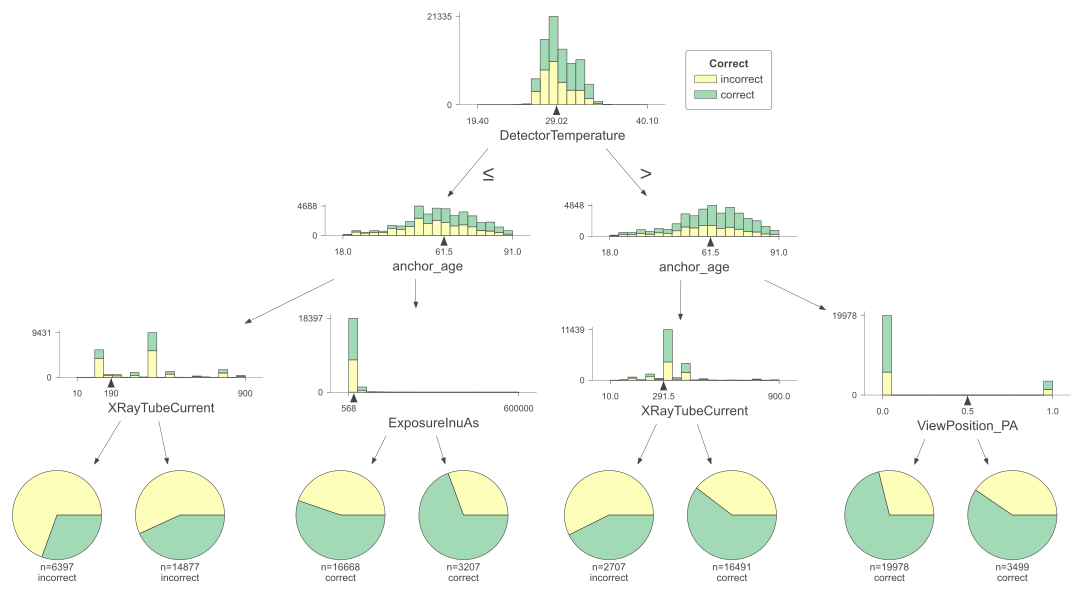

In [43]:
viz_model.view(scale=1.5)